In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from haversine import haversine, Unit
import numpy as np
import seaborn as sns

### Read in data/ Data Wrangling

Read in Sector shapefiles


In [2]:
shp_path=r"C:\Users\User\Documents\EHI\Projects\Wolbachia\Distance 2021\Sector SHP\Sectors_31122019.shp"
sector_shp = gpd.read_file(shp_path)
sector_shp = sector_shp.to_crs(epsg=4757)
sector_shp[sector_shp["Sector_ID"]=="FL292"].values
sector_shp["Mix"]=1

Read in dwelling data for each sector

In [18]:
#dwelling data for sector
dwelling = pd.read_csv("dwelling unit.csv")
dwelling.head()


,Sector_ID,TOTALDWELL
0,FL118,1993
1,FL119,1134
2,FL120,2285
3,FL121,1764
4,FL122,712


In [4]:
sector_shp.head()

,Sector_ID,ROAD_NAME,TYPE,RG2019,Division,CONSTITUEN,CDC,TOWN_COUNC,RO,GRC,Colour,geometry,Mix
0,CO1,CLEMENTI ROAD,RESIDENTIAL,2,Bukit Timah,Bukit Timah,North-West,Holland-Bukit Panjang,WRO,Holland-Bukit Timah,None,"POLYGON ((103.77784 1.33250, 103.77782 1.33120...",1
1,CO2,YARWOOD AVENUE,RESIDENTIAL,2,Bukit Timah,Bukit Timah,North-West,Holland-Bukit Panjang,WRO,Holland-Bukit Timah,None,"POLYGON ((103.78474 1.34218, 103.78478 1.34172...",1
2,CO3,GREENLEAF RISE,RESIDENTIAL,3,Ulu Pandan,Ulu Pandan,North-West,Holland-Bukit Panjang,WRO,Holland-Bukit Timah,None,"POLYGON ((103.78728 1.31995, 103.78805 1.31987...",1
3,CO4,DEPOT ROAD,RESIDENTIAL,2,Telok Blangah,Telok Blangah,South-West,West Coast,WRO,West Coast,None,"POLYGON ((103.80678 1.28142, 103.80690 1.28126...",1
4,CO5,KAMPONG BAHRU ROAD,RESIDENTIAL,2,Radin Mas SMC,Radin Mas SMC,Central,Tanjong Pagar,CRO,Radin Mas SMC,None,"POLYGON ((103.82020 1.27233, 103.82040 1.27210...",1


Read in sector to postal code mapping, add in 0 infront if needed. Get rid of duplicates in postal code

In [8]:
sector_mapping = pd.read_csv("Postal Sector Mapping.csv")
sector_mapping.head()
sector_mapping.info()
sector_mapping["Postal_Text"]=sector_mapping["Postal"].apply(lambda x: "S0" + str(x) if len(str(x))<6 else "S" + str(x))
sector_mapping.groupby("Postal")["Sector_ID"].nunique().sort_values(ascending=False)
sector_mapping = sector_mapping.drop_duplicates(subset="Postal")
sector_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145384 entries, 0 to 145383
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CONSTITUENCY  145384 non-null  object
 1   Sector_ID     145384 non-null  object
 2   Postal        145384 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 66700
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CONSTITUENCY  1331 non-null   object
 1   Sector_ID     1331 non-null   object
 2   Postal        1331 non-null   int64 
 3   Postal_Text   1331 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.0+ KB


In [9]:
sector_mapping.head()

,CONSTITUENCY,Sector_ID,Postal,Postal_Text
0,Chong Pang,FL278,760278,S760278
1,Chong Pang,FL278,760279,S760279
2,Chong Pang,FL278,760280,S760280
3,Chong Pang,FL278,760281,S760281
4,Chong Pang,FL278,760282,S760282


Get EWeek Calendar Frame

In [13]:
gai_calendar = pd.read_csv("GAI Calendar.csv")
gai_calendar.head()

,Index,Year,Eweek
0,1,2017,1
1,2,2017,2
2,3,2017,3
3,4,2017,4
4,5,2017,5


Take only the GAI needed from the masterframe

In [15]:
gai_data = pd.read_csv("GAI POSTAL 2017 2020EW53 (WITH XY).csv")
gai_data.info()
gai_data = gai_data.merge(gai_calendar,left_on=["eYear","eWeek"],right_on=["Year","Eweek"],how="left")
gai_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676886 entries, 0 to 2676885
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Postal_String    int64  
 1   Postal_Text      object 
 2   eYear            int64  
 3   eWeek            int64  
 4   adjusted_female  float64
 5   adjusted_traps   int64  
 6   Address          object 
 7   X                float64
 8   Y                float64
 9   Lat              float64
 10  Long             float64
dtypes: float64(5), int64(4), object(2)
memory usage: 224.7+ MB


,Postal_String,Postal_Text,eYear,eWeek,adjusted_female,adjusted_traps,Address,X,Y,Lat,Long,Index,Year,Eweek
0,50004,S050004,2017,1,0.0,3,4 SAGO LANE SINGAPORE 050004,29067.241846,29360.522264,1.281801,103.842908,1.0,2017.0,1.0
1,50004,S050004,2017,2,0.0,3,4 SAGO LANE SINGAPORE 050004,29067.241846,29360.522264,1.281801,103.842908,2.0,2017.0,2.0
2,50004,S050004,2017,3,0.0,3,4 SAGO LANE SINGAPORE 050004,29067.241846,29360.522264,1.281801,103.842908,3.0,2017.0,3.0
3,50004,S050004,2017,4,0.0,3,4 SAGO LANE SINGAPORE 050004,29067.241846,29360.522264,1.281801,103.842908,4.0,2017.0,4.0
4,50004,S050004,2017,5,0.0,3,4 SAGO LANE SINGAPORE 050004,29067.241846,29360.522264,1.281801,103.842908,5.0,2017.0,5.0


Merge the GAI data, and get only those for sectors represented in the Wolbachia site

In [16]:
#get gai by sector
gai_sector = gai_data.merge(sector_mapping[["Sector_ID","Postal_Text"]],on="Postal_Text",how="right")
len(set.intersection(set(gai_sector["Sector_ID"]),set(sector_mapping["Sector_ID"])))
len(set(sector_mapping["Sector_ID"])) # all 97 sectors are represented

97

In [17]:
gai_sector.head()

,Postal_String,Postal_Text,eYear,eWeek,adjusted_female,adjusted_traps,Address,X,Y,Lat,Long,Index,Year,Eweek,Sector_ID
0,760278,S760278,2017,1,0.5,4,278 YISHUN STREET 22 FICUS VALE SINGAPORE 760278,28546.217522,46666.988877,1.438314,103.838227,1.0,2017.0,1.0,FL278
1,760278,S760278,2017,2,0.5,4,278 YISHUN STREET 22 FICUS VALE SINGAPORE 760278,28546.217522,46666.988877,1.438314,103.838227,2.0,2017.0,2.0,FL278
2,760278,S760278,2017,3,0.0,5,278 YISHUN STREET 22 FICUS VALE SINGAPORE 760278,28546.217522,46666.988877,1.438314,103.838227,3.0,2017.0,3.0,FL278
3,760278,S760278,2017,4,0.0,5,278 YISHUN STREET 22 FICUS VALE SINGAPORE 760278,28546.217522,46666.988877,1.438314,103.838227,4.0,2017.0,4.0,FL278
4,760278,S760278,2017,5,0.0,5,278 YISHUN STREET 22 FICUS VALE SINGAPORE 760278,28546.217522,46666.988877,1.438314,103.838227,5.0,2017.0,5.0,FL278


#### Build dengue frame for every sector

Build a dengue masterframe for each sector, for Eweeks 1-52 for Year 2020

In [19]:
#get dengue by sector, build dengue frame
dengue_data = pd.read_csv("DEN-Hexagon DBF 2013_2020_complete.csv")
dengue_data.info()
sector_mapping.info()
dengue_data = dengue_data.merge(sector_mapping[["Sector_ID","Postal"]],left_on="POSTAL",right_on="Postal")
dengue_sector = dengue_data.groupby(["Onset_EYear","Onset_EWeek","Sector_ID"])["CASE_ID"].count().reset_index()
dengue_sector["CASE_ID"].max()
#dengue_sector.to_csv("dengue_sector.csv",index=False)

common_sectors = list(set.intersection(set(dengue_data["Sector_ID"]),set(sector_mapping["Sector_ID"])))

dengue_frame=[]
for sector_index in range(0,len(common_sectors)):
    each_sector = common_sectors[sector_index]
    mainframe = gai_calendar.iloc[156:209]
    mainframe["Sector_ID"]=each_sector
    add_dengue = dengue_sector[dengue_sector["Sector_ID"]==each_sector]
    dengue_set = mainframe.merge(add_dengue,left_on = ["Year","Eweek"],right_on=["Onset_EYear","Onset_EWeek"],how="left")
    dengue_frame.append(dengue_set)

dengue_frame = pd.concat(dengue_frame)
dengue_frame.info()
dengue_frame = dengue_frame[['Index', 'Year', 'Eweek', 'Sector_ID_x',  'CASE_ID']]
dengue_frame=dengue_frame.rename(columns={"Sector_ID_x":"Sector_ID"})
dengue_frame.fillna(0,inplace=True)
dengue_frame = dengue_frame.merge(dwelling,on="Sector_ID")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119645 entries, 0 to 119644
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CASE_ID      119645 non-null  object 
 1   CLUSTER_ID   119645 non-null  int64  
 2   Onset_EYear  119645 non-null  int64  
 3   Onset_EWeek  119645 non-null  int64  
 4   Clean_Onset  119645 non-null  object 
 5   ONSET_DATE   119644 non-null  object 
 6   NEA_ONSET_   119645 non-null  object 
 7   NOTIFY_DAT   119645 non-null  object 
 8   POSTAL       119645 non-null  int64  
 9   X output     119645 non-null  float64
 10  Y output     119645 non-null  float64
 11  cell_id      119645 non-null  int64  
 12  friendly_n   119645 non-null  object 
 13  Shape_Leng   119645 non-null  float64
 14  Shape_Area   119645 non-null  float64
dtypes: float64(4), int64(5), object(6)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 66700
Data columns (total 

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5141 entries, 0 to 52
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Index        5141 non-null   int64  
 1   Year         5141 non-null   int64  
 2   Eweek        5141 non-null   int64  
 3   Sector_ID_x  5141 non-null   object 
 4   Onset_EYear  911 non-null    float64
 5   Onset_EWeek  911 non-null    float64
 6   Sector_ID_y  911 non-null    object 
 7   CASE_ID      911 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 361.5+ KB


In [21]:
dengue_frame.head(5)

,Index,Year,Eweek,Sector_ID,CASE_ID,TOTALDWELL
0,157,2020,1,FL308,0.0,1740
1,158,2020,2,FL308,0.0,1740
2,159,2020,3,FL308,0.0,1740
3,160,2020,4,FL308,0.0,1740
4,161,2020,5,FL308,0.0,1740


#### Build virgin frame - one for TP and YS

Get the polygons for each virgin, combine it, and find the respective centroids.

<AxesSubplot:>

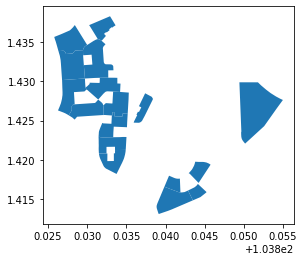

In [22]:
#build virgin frame
virgins = pd.read_csv("virgins.csv")
virgins.head()
virgins.groupby("Area").size()

#virgins for TP
virgins_tp = virgins[virgins["Area"]=="TP"].merge(sector_shp,on="Sector_ID")
virgins_tp["centroid"] = virgins_tp["geometry"].apply(lambda x: x.centroid)
virgins_tp.head()


#virgins for YS and centroids
virgins_ys = virgins[virgins["Area"]=="YS"].merge(sector_shp,on="Sector_ID")
virgins_ys["centroid"] = virgins_ys["geometry"].apply(lambda x: x.centroid)
virgins_ys.head()
virgins_ys["Sector_ID"]
v1 = sector_shp[sector_shp["Sector_ID"].isin(virgins_ys["Sector_ID"])]
v1.plot()


#### Build frame for the release sites

Contains the polygons for all the release sites. Each phase has to be merged to find the centroid.

In [23]:
#build release sites frame
release_sites = pd.read_csv("TP YS Release Sectors.csv")
release_sites = release_sites.merge(sector_shp,on="Sector_ID",how="left")
release_sites = release_sites.merge(gai_calendar,left_on=["Release Year","Release Week"],right_on = ["Year","Eweek"],how="left")

In [25]:
release_sites.head()

,Area,Phase,True Phase,Sector_ID,Release Year,Release Month,Release Week,ROAD_NAME,TYPE,RG2019,...,CDC,TOWN_COUNC,RO,GRC,Colour,geometry,Mix,Index,Year,Eweek
0,TP,4.0,4.0,FL332,2020,Feb,8,TAMPINES STREET 11,RESIDENTIAL,3,...,North-East,Tampines,ERO,Tampines,None,"POLYGON ((103.94885 1.34566, 103.94863 1.34554...",1,164,2020,8
1,TP,4.0,4.0,FL121,2020,Feb,8,TAMPINES STREET 22,RESIDENTIAL,4,...,North-East,Tampines,ERO,Tampines,None,"POLYGON ((103.95146 1.34802, 103.95146 1.34802...",1,164,2020,8
2,TP,4.0,4.0,FL120,2020,Feb,8,TAMPINES AVENUE 2,RESIDENTIAL,4,...,North-East,Tampines,ERO,Tampines,None,"POLYGON ((103.95540 1.34871, 103.95474 1.34815...",1,164,2020,8
3,TP,4.0,4.0,FL118,2020,Feb,8,TAMPINES STREET 21,RESIDENTIAL,4,...,North-East,Tampines,ERO,Tampines,None,"POLYGON ((103.94832 1.35162, 103.94856 1.35161...",1,164,2020,8
4,TP,4.0,4.0,FL304,2020,Feb,8,TAMPINES STREET 21,RESIDENTIAL,4,...,North-East,Tampines,ERO,Tampines,None,"POLYGON ((103.95117 1.35462, 103.95132 1.35447...",1,164,2020,8


#### Helper functions (ignore)

In [26]:
def end_index(input_index):
    try:
        end_index=release_sites.iloc[input_index+1]["Index"]
    except:
        end_index=209 #ew 53 of 2020
    return end_index


### Build loop for GAI

I show an example for TP, for YS repeat but change parameters

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to

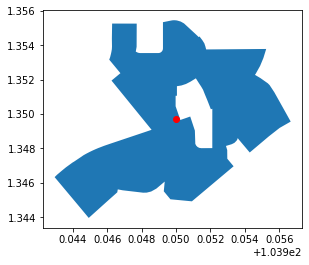

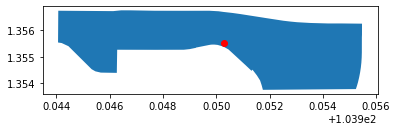

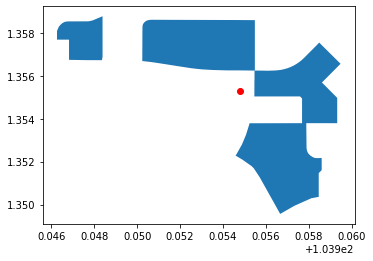

In [28]:
import helper_functions as hf

#SAVE RESULTS OUT OF LOOP
all_phase_results = []
phases = [4,4.1,5]
area = "TP"

data_frame= virgins_tp.copy(deep=True) #deep copy to avoid touching original file
for each_phase in phases:
    
    #get shp centroid of release sites
    phase_no = each_phase;area_no =area
    release_cand = release_sites[(release_sites["Phase"]==phase_no) & (release_sites["Area"]==area_no)]
    
    #gai dates for slicing
    release_start_index = release_sites.iloc[release_cand.index[0]]["Index"]
    release_end_index = end_index(release_cand.index[-1]) #take from last row to get next week row
    if area=="TP" and release_start_index==207:
        release_end_index = 209 #need to hard code this one in because last row of TP will go to YS
    
    #merge the release sites into one huge polygon
    combined_release=sector_shp[sector_shp["Sector_ID"].isin(release_cand["Sector_ID"])]
    combined_release = combined_release.dissolve("Mix")
    #plot the combined release polygons and its centroid
    ax =combined_release.plot();combined_release.centroid.plot(ax=ax,c="r")
    
    #pint(combined_release.centroid.y,combined_release.centroid.x)
    
    #distance between release centroid and centroid of other virgins, lat and long 1.420123,103.836114
    virgin_sheet = data_frame
    virgin_sheet["Dist"]=virgin_sheet["centroid"].apply(lambda z: haversine((z.y,z.x),\
                (combined_release.centroid.y,combined_release.centroid.x)))
    virgin_sheet["Dist Interval"] = virgin_sheet["Dist"].apply(lambda x: hf.dist_map(x))
    #rint(virgin_sheet["Dist"])
    virgin_sheet.sort_values("Dist",inplace=True)
    virgin_sheet.reset_index(drop=True,inplace=True)
    
    
    ## GAI for virgins by week
    release_site_results = [] #for one release site
    for grp in virgin_sheet["Dist Interval"].unique():
        dist_group = grp #calculate GAI for each distance grp, by weeks
        #print(dist_group)
        sector_filter = virgin_sheet[virgin_sheet["Dist Interval"]==dist_group]["Sector_ID"].values
        date_range = np.arange(release_start_index,release_end_index)
        gai_sheet_raw=gai_sector[(gai_sector["Sector_ID"].isin(sector_filter)) & (gai_sector["Index"].isin(date_range))]
        gai_sheet = gai_sheet_raw.groupby(["eYear","eWeek"]).agg({'adjusted_female':"sum", 'adjusted_traps': 'sum'}).reset_index()
        gai_sheet["GAI"]=gai_sheet["adjusted_female"]/gai_sheet["adjusted_traps"]
        gai_sheet["Dist Interval"]=dist_group
        gai_sheet["Area"]=area_no
        gai_sheet["Release_Site"]=phase_no
        release_site_results.append(gai_sheet)

    
    ## GAI for releases by week
    gai_release_raw = gai_sector[(gai_sector["Sector_ID"].isin(release_cand["Sector_ID"])) & (gai_sector["Index"].isin(date_range))]
    gai_release = gai_release_raw.groupby(["eYear","eWeek"]).agg({'adjusted_female':"sum", 'adjusted_traps': 'sum'}).reset_index() 
    gai_release = gai_release.rename(columns={"adjusted_female":"release_female","adjusted_traps":"release_traps"})
    gai_release["GAI Release"]=gai_release["release_female"]/gai_release["release_traps"]
    
    #combine release GAI and virgin GAI here to compute GAI RR
    phase_result = pd.concat(release_site_results)
    phase_result = phase_result.merge(gai_release,on=["eYear","eWeek"]).sort_values(["Dist Interval","eWeek"])
    phase_result.reset_index(drop=True,inplace=True)
    phase_result["eYear"]=phase_result["eYear"].astype(int)
    phase_result["eWeek"]=phase_result["eWeek"].astype(int)
    
    phase_result["GAI Rate Ratio"]=phase_result["GAI"]/phase_result["GAI Release"]
    
    phase_result["GAI_log"]=np.log(phase_result["GAI Rate Ratio"])
    phase_result["GAI_logSE"]=phase_result[["adjusted_female","release_female"]].apply(lambda x: np.sqrt((1/x[0])+(1/x[1])),axis=1)
    phase_result["GAI_UB"]=np.exp(phase_result["GAI_log"]+1.96*phase_result["GAI_logSE"])
    phase_result["GAI_LB"]=np.exp(phase_result["GAI_log"]-1.96*phase_result["GAI_logSE"])
   # plt.title(f"Phase {phase_no} Area {area_no}");sns.barplot(x="eWeek",y="GAI",hue="Dist Interval",data=phase_result)
    all_phase_results.append(phase_result)

In [30]:
gai_tp = pd.concat(all_phase_results)
gai_tp.head()

,eYear,eWeek,adjusted_female,adjusted_traps,GAI,Dist Interval,Area,Release_Site,release_female,release_traps,GAI Release,GAI Rate Ratio,GAI_log,GAI_logSE,GAI_UB,GAI_LB
0,2020,8,89.0,726,0.122590,C,TP,4.0,110.0,530,0.207547,0.590659,-0.526517,0.142572,0.781082,0.446659
1,2020,9,81.5,724,0.112569,C,TP,4.0,104.5,536,0.194963,0.577388,-0.549241,0.147781,0.771368,0.432189
2,2020,10,81.5,724,0.112569,C,TP,4.0,104.5,536,0.194963,0.577388,-0.549241,0.147781,0.771368,0.432189
3,2020,11,70.5,722,0.097645,C,TP,4.0,76.0,535,0.142056,0.687372,-0.374879,0.165355,0.950485,0.497095
4,2020,12,70.5,722,0.097645,C,TP,4.0,76.0,535,0.142056,0.687372,-0.374879,0.165355,0.950485,0.497095


### Loop for Dengue

I show an example for Yishun

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\User\Anaconda3\envs\branch-env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to

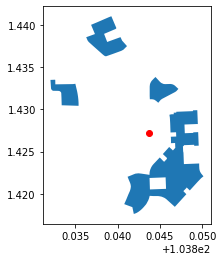

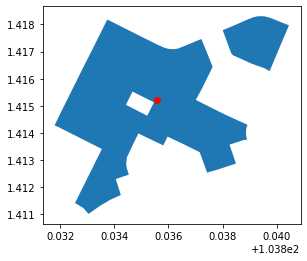

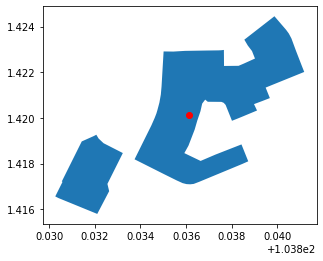

In [32]:
all_phase_results = []
check_sheet= []
phases = [4.1,5,5.1]
area = "YS"
data_frame= virgins_ys.copy(deep=True) #load in centroids of virgins
for each_phase in phases:
    
    #centroid of release sites
    phase_no = each_phase;area_no =area
    release_cand = release_sites[(release_sites["Phase"]==phase_no) & (release_sites["Area"]==area_no)]
    
    #gai dates for slicing
    release_start_index = release_sites.iloc[release_cand.index[0]]["Index"]
    #release_sites.iloc[release_cand.index[-1]+1]["Index"]

    release_end_index = end_index(release_cand.index[-1]) #take from last row to get next week row
    
    #need to hardcode this part in else will read in YS
    if area=="TP" and release_start_index==207:
        release_end_index = 209
    
    #merge the release sites into one huge polygon
    combined_release=sector_shp[sector_shp["Sector_ID"].isin(release_cand["Sector_ID"])]
    combined_release = combined_release.dissolve("Mix")
    #plot the combined release polygons and its centroid
    ax =combined_release.plot();combined_release.centroid.plot(ax=ax,c="r")
    
   # print(combined_release.centroid.y,combined_release.centroid.x)
    
    #distance between release centroid and centroid of other virgins, lat and long 1.420123,103.836114
    virgin_sheet = data_frame
    virgin_sheet["Dist"]=virgin_sheet["centroid"].apply(lambda z: haversine((z.y,z.x),\
                (combined_release.centroid.y,combined_release.centroid.x)))
    virgin_sheet["Dist Interval"] = virgin_sheet["Dist"].apply(lambda x: hf.dist_map(x))
    #print(virgin_sheet["Dist"])
    virgin_sheet.sort_values("Dist",inplace=True)
    virgin_sheet.reset_index(drop=True,inplace=True)
   # check_sheet.append(virgin_sheet)
    
    
    ## Dengue for virgins by week
    release_site_results = [] #for one release site/ phase
    for grp in virgin_sheet["Dist Interval"].unique():
        dist_group = grp
        #print(dist_group)
        sector_filter = virgin_sheet[virgin_sheet["Dist Interval"]==dist_group]["Sector_ID"].values
        date_range = np.arange(release_start_index,release_end_index)
        dengue_sheet_raw=dengue_frame[(dengue_frame["Sector_ID"].isin(sector_filter)) & (dengue_frame["Index"].isin(date_range))]
        dengue_sheet = dengue_sheet_raw.groupby(["Year","Eweek"]).agg({'CASE_ID':"sum", 'TOTALDWELL': 'mean'}).reset_index()
       # dengue_sheet["Dengue Incidence"]=dengue_sheet["CASE_ID"]/dengue_sheet["TOTALDWELL"]
        dengue_sheet["Dist Interval"]=dist_group
        dengue_sheet["Area"]=area_no
        dengue_sheet["Release_Site"]=phase_no
        release_site_results.append(dengue_sheet)
        #print(gai_sheet)
        #gai_sheet_raw.to_csv(f"gai_{dist_group}.csv")
    
    ## Dengue for releases by week
    dengue_release_raw = dengue_frame[(dengue_frame["Sector_ID"].isin(release_cand["Sector_ID"])) & (dengue_frame["Index"].isin(date_range))]
    dengue_release = dengue_release_raw.groupby(["Year","Eweek"]).agg({'CASE_ID':"sum", 'TOTALDWELL': 'mean'}).reset_index()
    dengue_release = dengue_release.rename(columns={"CASE_ID":"Release Cases","TOTALDWELL":"Release Dwell"})
    #dengue_sheet["Release Dengue Incidence"]=dengue_release["Release Cases"]/dengue_release["Release Dwell"]
    
    phase_result = pd.concat(release_site_results)
    phase_result = phase_result.merge(dengue_release,on=["Year","Eweek"]).sort_values(["Dist Interval","Eweek"])
    phase_result.reset_index(drop=True,inplace=True)
    phase_result["Year"]=phase_result["Year"].astype(int)
    phase_result["Eweek"]=phase_result["Eweek"].astype(int)


    all_phase_results.append(phase_result)

In [33]:
dengue_ys=pd.concat(all_phase_results)
dengue_ys.head()

,Year,Eweek,CASE_ID,TOTALDWELL,Dist Interval,Area,Release_Site,Release Cases,Release Dwell
0,2020,7,1.0,924.666667,B,YS,4.1,0.0,1449.727273
1,2020,8,0.0,924.666667,B,YS,4.1,2.0,1449.727273
2,2020,9,0.0,924.666667,B,YS,4.1,1.0,1449.727273
3,2020,10,0.0,924.666667,B,YS,4.1,1.0,1449.727273
4,2020,11,0.0,924.666667,B,YS,4.1,0.0,1449.727273
